In [1]:
import numpy as np
import scipy as sp
import scipy.special as sps
import scipy.constants as cons
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

In [2]:
def get_alpha(theta, length):
    '''
    Finds the acceleration of the pendulum as a function of the angle and the length.

    Arguments
    ---------
    theta : np.ndarray, (1,)
    The angle of the pendulum arm with respect to the normal.

    length : np.ndarray, (1,)
    The length of the pendulum arm.

    Returns
    -------
    alpha : np.ndarray, (1,)
    The net acceleration, in the theta direction.
    '''

    alpha = -cons.g/length * np.sin(theta)
    return alpha

In [3]:
def runge_kutta_1(theta, omega, length, dt=1e-3):
    '''
    Advances the system through a timestep of 'dt' seconds using Runge-Kutta 1:
    takes in the state at some time t and the change, returns the state at time t + dt.
    This is also known as Simple Euler's Method.

    Arguments
    ---------
    theta, omega, length : np.ndarray, (1,)
    The angle, velocity, length of the pendulums.

    dt : scalar, optional
    The timestep variable.

    Returns
    -------
    ntheta, nomega : np.ndarray, (N,)
    The new state of the system.
    '''

    alpha = get_alpha(theta, length)
    nomega = omega + alpha*dt
    ntheta = theta + omega*dt
    return ntheta, nomega

In [4]:
def runge_kutta_2(theta, omega, length, dt=1e-3):
    '''
    Advances the system through a timestep of 'dt' seconds using Runge-Kutta 2:
    takes in the state at some time t and the change, returns the state at time t + dt.

    Arguments
    ---------
    theta, omega, length : np.ndarray, (1,)
    The angle, velocity, length of the pendulums.

    dt : scalar, optional
    The timestep variable.

    Returns
    -------
    ntheta, nomega : np.ndarray, (N,)
    The new state of the system.
    '''

    k1o = get_alpha(theta, length)*dt
    k1t = omega*dt

    k2o = get_alpha(theta+0.5*k1t, length)*dt
    k2t = (omega + 0.5*k1o)*dt

    nomega = omega + k2o
    ntheta = theta + k2t

    return ntheta, nomega


In [5]:
def runge_kutta_3(theta, omega, length, dt=1e-3):
    '''
    Advances the system through a timestep of 'dt' seconds using Runge-Kutta 3:
    takes in the state at some time t and the change, returns the state at time t + dt.

    Arguments
    ---------
    theta, omega, length : np.ndarray, (1,)
    The angle, velocity, length of the pendulums.

    dt : scalar, optional
    The timestep variable.

    Returns
    -------
    ntheta, nomega : np.ndarray, (N,)
    The new state of the system.
    '''

    k1o = get_alpha(theta, length)*dt
    k1t = omega*dt

    k2o = get_alpha(theta+0.5*k1t, length)*dt
    k2t = (omega + 0.5*k1o)*dt

    k3o = get_alpha(theta+(2*k2t - k1t), length)*dt
    k3t = (omega + (2*k2o-k1o))*dt

    nomega = omega + (k1o + 4*k2o + k3o)/6
    ntheta = theta + (k1t + 4*k2t + k3t)/6

    return ntheta, nomega

In [6]:
def runge_kutta_4(theta, omega, length, dt=1e-3):
    '''
    Advances the system through a timestep of 'dt' seconds using Runge-Kutta 4:
    takes in the state at some time t and the change, returns the state at time t + dt.

    Arguments
    ---------
    theta, omega, length : np.ndarray, (1,)
    The angle, velocity, length of the pendulums.

    dt : scalar, optional
    The timestep variable.

    Returns
    -------
    ntheta, nomega : np.ndarray, (N,)
    The new state of the system.
    '''

    k1o = get_alpha(theta, length)*dt
    k1t = omega*dt

    k2o = get_alpha(theta+0.5*k1t, length)*dt
    k2t = (omega + 0.5*k1o)*dt

    k3o = get_alpha(theta+0.5*k2t, length)*dt
    k3t = (omega + 0.5*k2o)*dt

    k4o = get_alpha(theta+k3t, length)*dt
    k4t = (omega + k3o)*dt

    nomega = omega + (k1o + 2*k2o + 2*k3o + k4o)/6
    ntheta = theta + (k1t + 2*k2t + 2*k3t + k4t)/6

    return ntheta, nomega

In [45]:
K = sps.ellipk # this is the complete elliptic integral of the first kind, provided by scipy

def q(m):
    '''
    The elliptic nome function.
    '''
    return np.exp(-np.pi*K(1-m)/K(m))

def theta_s(z, m):
    '''
    One of the Neville Theta Functions, taking two parameters.
    '''
    a = ((np.sqrt(2*np.pi)*(q(m))**(1/4))/((m*(1-m))**(1/4)*np.sqrt(K(m))))
    k = np.arange(10000)
    sum = np.sum( (-1)**k * ((q(m))**(k*(k+1))) * np.sin(((2*k+1)*np.pi*z) / (2*K(m))) )
    return a * sum

def theta_n(z, m):
    '''
    One of the Neville Theta Functions, taking two parameters.
    '''
    a = ((np.sqrt(2*np.pi))/(2*(1-m)**(1/4)*np.sqrt(K(m))))
    k = np.arange(1, 10000)
    sum = np.sum( (-1)**k * ((q(m))**(k**2)) * np.cos((k*np.pi*z) / (K(m))) )
    return a * (1+2*sum) 

def sn(z, m):
    '''
    One of the twelve Jacobi elliptic functions used in the analytical solution for the pendulum
    '''
    return theta_s(z, m)/theta_n(z, m)

def theta_analytic(t, theta_0, length):
    '''
    The analytic solution to the pendulum as a function of time.

    Arguments
    ---------
    t : float
    The time of the desired state

    theta_0 : float
    The initial angle of the pendulum measured from the vertical

    length : float
    The length of the pendulum
    '''
    omega_0 = np.sqrt(cons.g/length)
    return 2*np.arcsin(np.sin(theta_0/2) * sn(K(np.sin(theta_0/2)**2) - omega_0*t, (np.sin(theta_0/2))**2))

In [40]:
def simulate(times, theta_0, length, dt=1e-3, step_fn=runge_kutta_1):
    num_steps = len(times)
    theta_arr = np.zeros(num_steps)
    theta = theta_0
    omega = 0
    for t in range(num_steps):
        theta_arr[t] = theta
        theta, omega = step_fn(theta, omega, length, dt)
    return theta_arr

In [44]:
def sim_runner(angle_i, length, duration, deltatime=1e-3):
    '''
    Runs every type of simulation method and the analytical solution over the given parameters

    Arguments
    ---------
    angle_i : float
    Initial angle in degrees, measured CCW from the vertical

    length : float
    The length of the pendulum arm

    duration : float
    The time in seconds of simulation

    deltatime : scalar, optional
    The timestep used between each computation in the Runge-Kutta methods.
    The Analytic and SHM simulations will run to match the Runge-Kutta data in timesteps.
    '''
    theta_0 = np.pi / 180 * np.array([angle_i])
    times = np.arange(0, duration+deltatime, deltatime)

    theta_an = np.array([theta_analytic(t, theta_0, length) for t in times]).T[0]
    theta_shm = theta_0 * np.cos( np.sqrt(cons.g / length) * times)
    theta_rk1 = simulate(times, theta_0, length, step_fn=runge_kutta_1, dt=deltatime)
    theta_rk2 = simulate(times, theta_0, length, step_fn=runge_kutta_2, dt=deltatime)
    theta_rk3 = simulate(times, theta_0, length, step_fn=runge_kutta_3, dt=deltatime)
    theta_rk4 = simulate(times, theta_0, length, step_fn=runge_kutta_4, dt=deltatime)
    return np.array([times, theta_an, theta_shm, theta_rk1, theta_rk2, theta_rk3, theta_rk4])

In [31]:
def plot_sims(times, theta_an, theta_shm, theta_rk1, theta_rk2, theta_rk3, theta_rk4, angle_i, duration):
    '''
    Plots the simulations run given the data provided. Will plot all 5 types of simulations and
    the analytic solution.
    '''
    fig_sim, axs = plt.subplots(6, figsize=(15,20), constrained_layout=True)
    fig_sim.suptitle(r"Simulations, $\theta _0 = {0}^\circ$".format(angle_i), size='xx-large')
    for ax in axs:
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Angle of pendulum (rad)")
        loc = plticker.MultipleLocator(base=duration/20) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)

    ax = axs[0]
    ax.plot(times, theta_an)
    ax.set_title("Analytic Solution")

    ax = axs[1]
    ax.plot(times, theta_shm)
    ax.set_title("Simple Harmonic Motion")

    ax = axs[2]
    euler = (theta_rk1 + np.pi) % (2*np.pi) - np.pi
    ax.plot(times, theta_rk1)
    ax.set_title("Runge-Kutta 1 (Simple Euler's Method)")

    ax = axs[3]
    ax.plot(times, theta_rk2)
    ax.set_title("Runge-Kutta 2")

    ax = axs[4]
    ax.plot(times, theta_rk3)
    ax.set_title("Runge-Kutta 3")

    ax = axs[5]
    ax.plot(times, theta_rk4)
    ax.set_title("Runge-Kutta 4")
    plt.show()

In [41]:
def plot_errors(times, theta_an, theta_shm, theta_rk1, theta_rk2, theta_rk3, theta_rk4, angle_i, duration):
    '''
    Plots the errors of each simulation method given the data provided. Will plot all 5 types of simulations and
    the analytic solution.
    '''
    fig_error, axs = plt.subplots(3,2, figsize=(20, 16), constrained_layout=True, dpi=100)
    fig_error.suptitle(r"Error of Simulations Methods in comparison to Analytic Solution $\theta _0 = {0}^\circ$".format(angle_i), size='xx-large')

    for ax in axs.ravel():
        ax.set_xlabel("Time (s)", size='large')
        ax.set_ylabel("Angle Error (rad)", size='large')
        loc = plticker.MultipleLocator(base=duration/20) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)

    ax = axs[0,0]
    ax.plot(times, theta_an)
    ax.set_title("Analytic Solution")
    ax.set_ylabel("Angel of pendulum (rad)", size='large')

    ax = axs[0,1]
    ax.plot(times, theta_shm-theta_an)
    ax.set_title(r'SHM $-$ Analytic Solution', size='x-large')

    euler = (theta_rk1 + np.pi) % (2*np.pi) - np.pi
    ax = axs[1,0]
    ax.plot(times, theta_rk1-theta_an)
    ax.set_title(r'RK1 $-$ Analytic Solution', size='x-large')

    ax = axs[1,1]
    ax.plot(times, theta_rk2-theta_an)
    ax.set_title(r'RK2 $-$ Analytic Solution', size='x-large')

    ax = axs[2,0]
    ax.set_title(r'RK3 $-$ Analytic Solution', size='x-large')
    ax.plot(times, theta_rk3-theta_an)

    ax = axs[2,1]
    ax.plot(times, theta_rk4-theta_an)
    ax.set_title(r'RK4 $-$ Analytic Solution', size='x-large')

    plt.show()

In [42]:
def plot_rkdiffs(times, theta_rk1, theta_rk2, theta_rk3, theta_rk4, angle_i, duration):
    '''
    Plots the differences between the Runge-Kutta methods run given the data provided.
    Will plot all combinations of th e4 types of Runge-Kutta methods.
    '''
    fig_error, axs = plt.subplots(3,2, figsize=(20, 16), constrained_layout=True, dpi=100)
    fig_error.suptitle(r"Differences between Runge-Kutta Simulations $\theta _0 = {0}^\circ$".format(angle_i), size='xx-large')

    for ax in axs.ravel():
    # theta_rk1 = euler    ax.set_xlabel("Time (s)", size='large')
        ax.set_ylabel("Angle Error (rad)", size='large')
        loc = plticker.MultipleLocator(base=duration/20) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)

    ax = axs[0,0]
    euler = (theta_rk1 + np.pi) % (2*np.pi) - np.pi
    # theta_rk1 = euler
    ax.plot(times, theta_rk2-theta_rk1)
    ax.set_title(r'RK2 $-$ RK1', size='x-large')

    ax = axs[1,0]
    ax.plot(times, theta_rk3-theta_rk1)
    ax.set_title(r'RK3 $-$ RK1', size='x-large')

    ax = axs[2,0]
    ax.plot(times, theta_rk3-theta_rk2)
    ax.set_title(r'RK3 $-$ RK2', size='x-large')

    ax = axs[0,1]
    ax.plot(times, theta_rk4-theta_rk1)
    ax.set_title(r'RK4 $-$ RK1', size='x-large')

    ax = axs[1,1]
    ax.set_title(r'RK4 $-$ RK2', size='x-large')
    ax.plot(times, theta_rk4-theta_rk2)

    ax = axs[2,1]
    ax.plot(times, theta_rk4-theta_rk3)
    ax.set_title(r'RK4 $-$ RK3', size='x-large')

    plt.show()

In [27]:
angle_i = 179 #degrees
duration = 10 #seconds
sim_data = sim_runner(angle_i=angle_i, length=np.array(1), duration=duration, deltatime=1e-3)

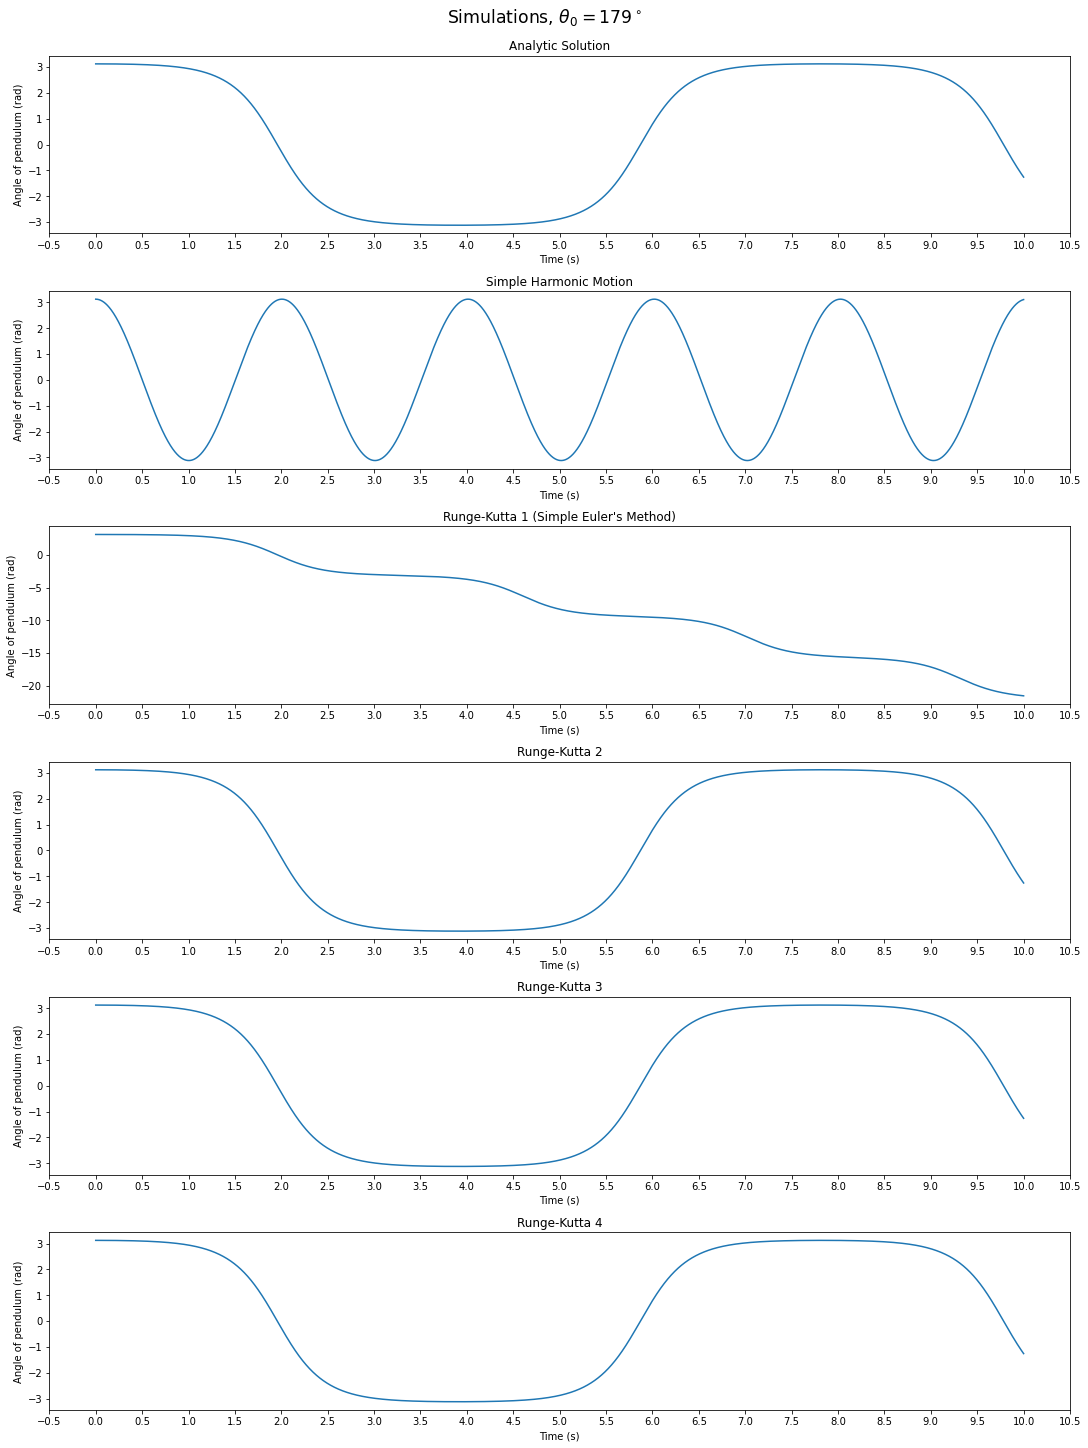

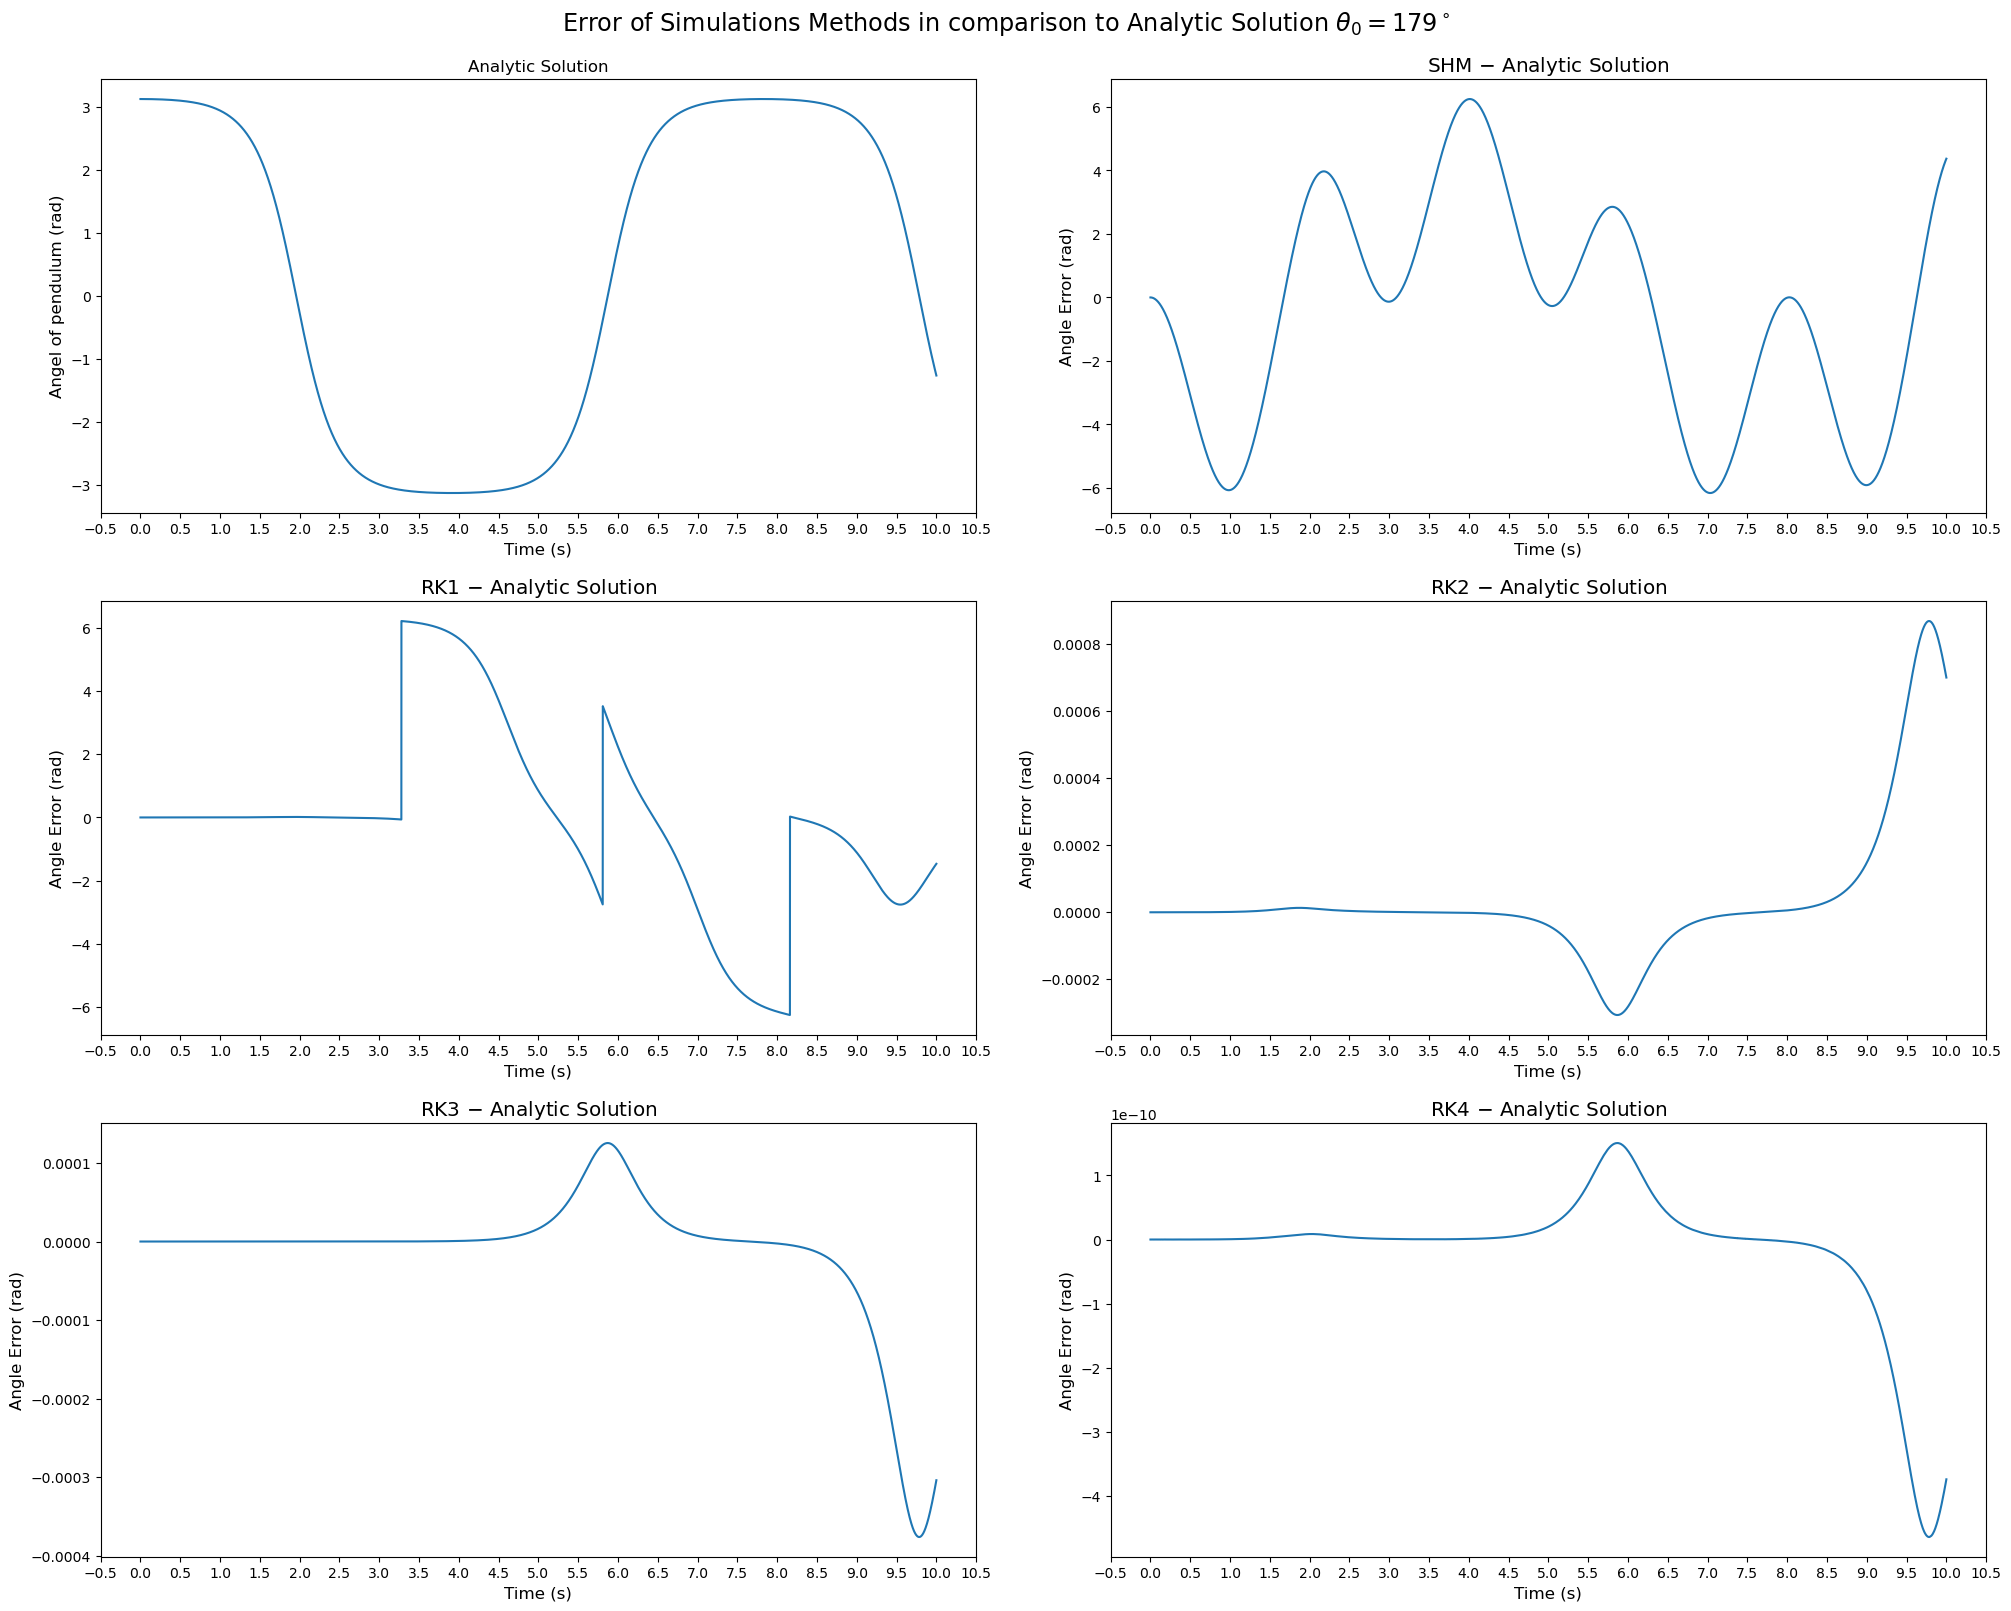

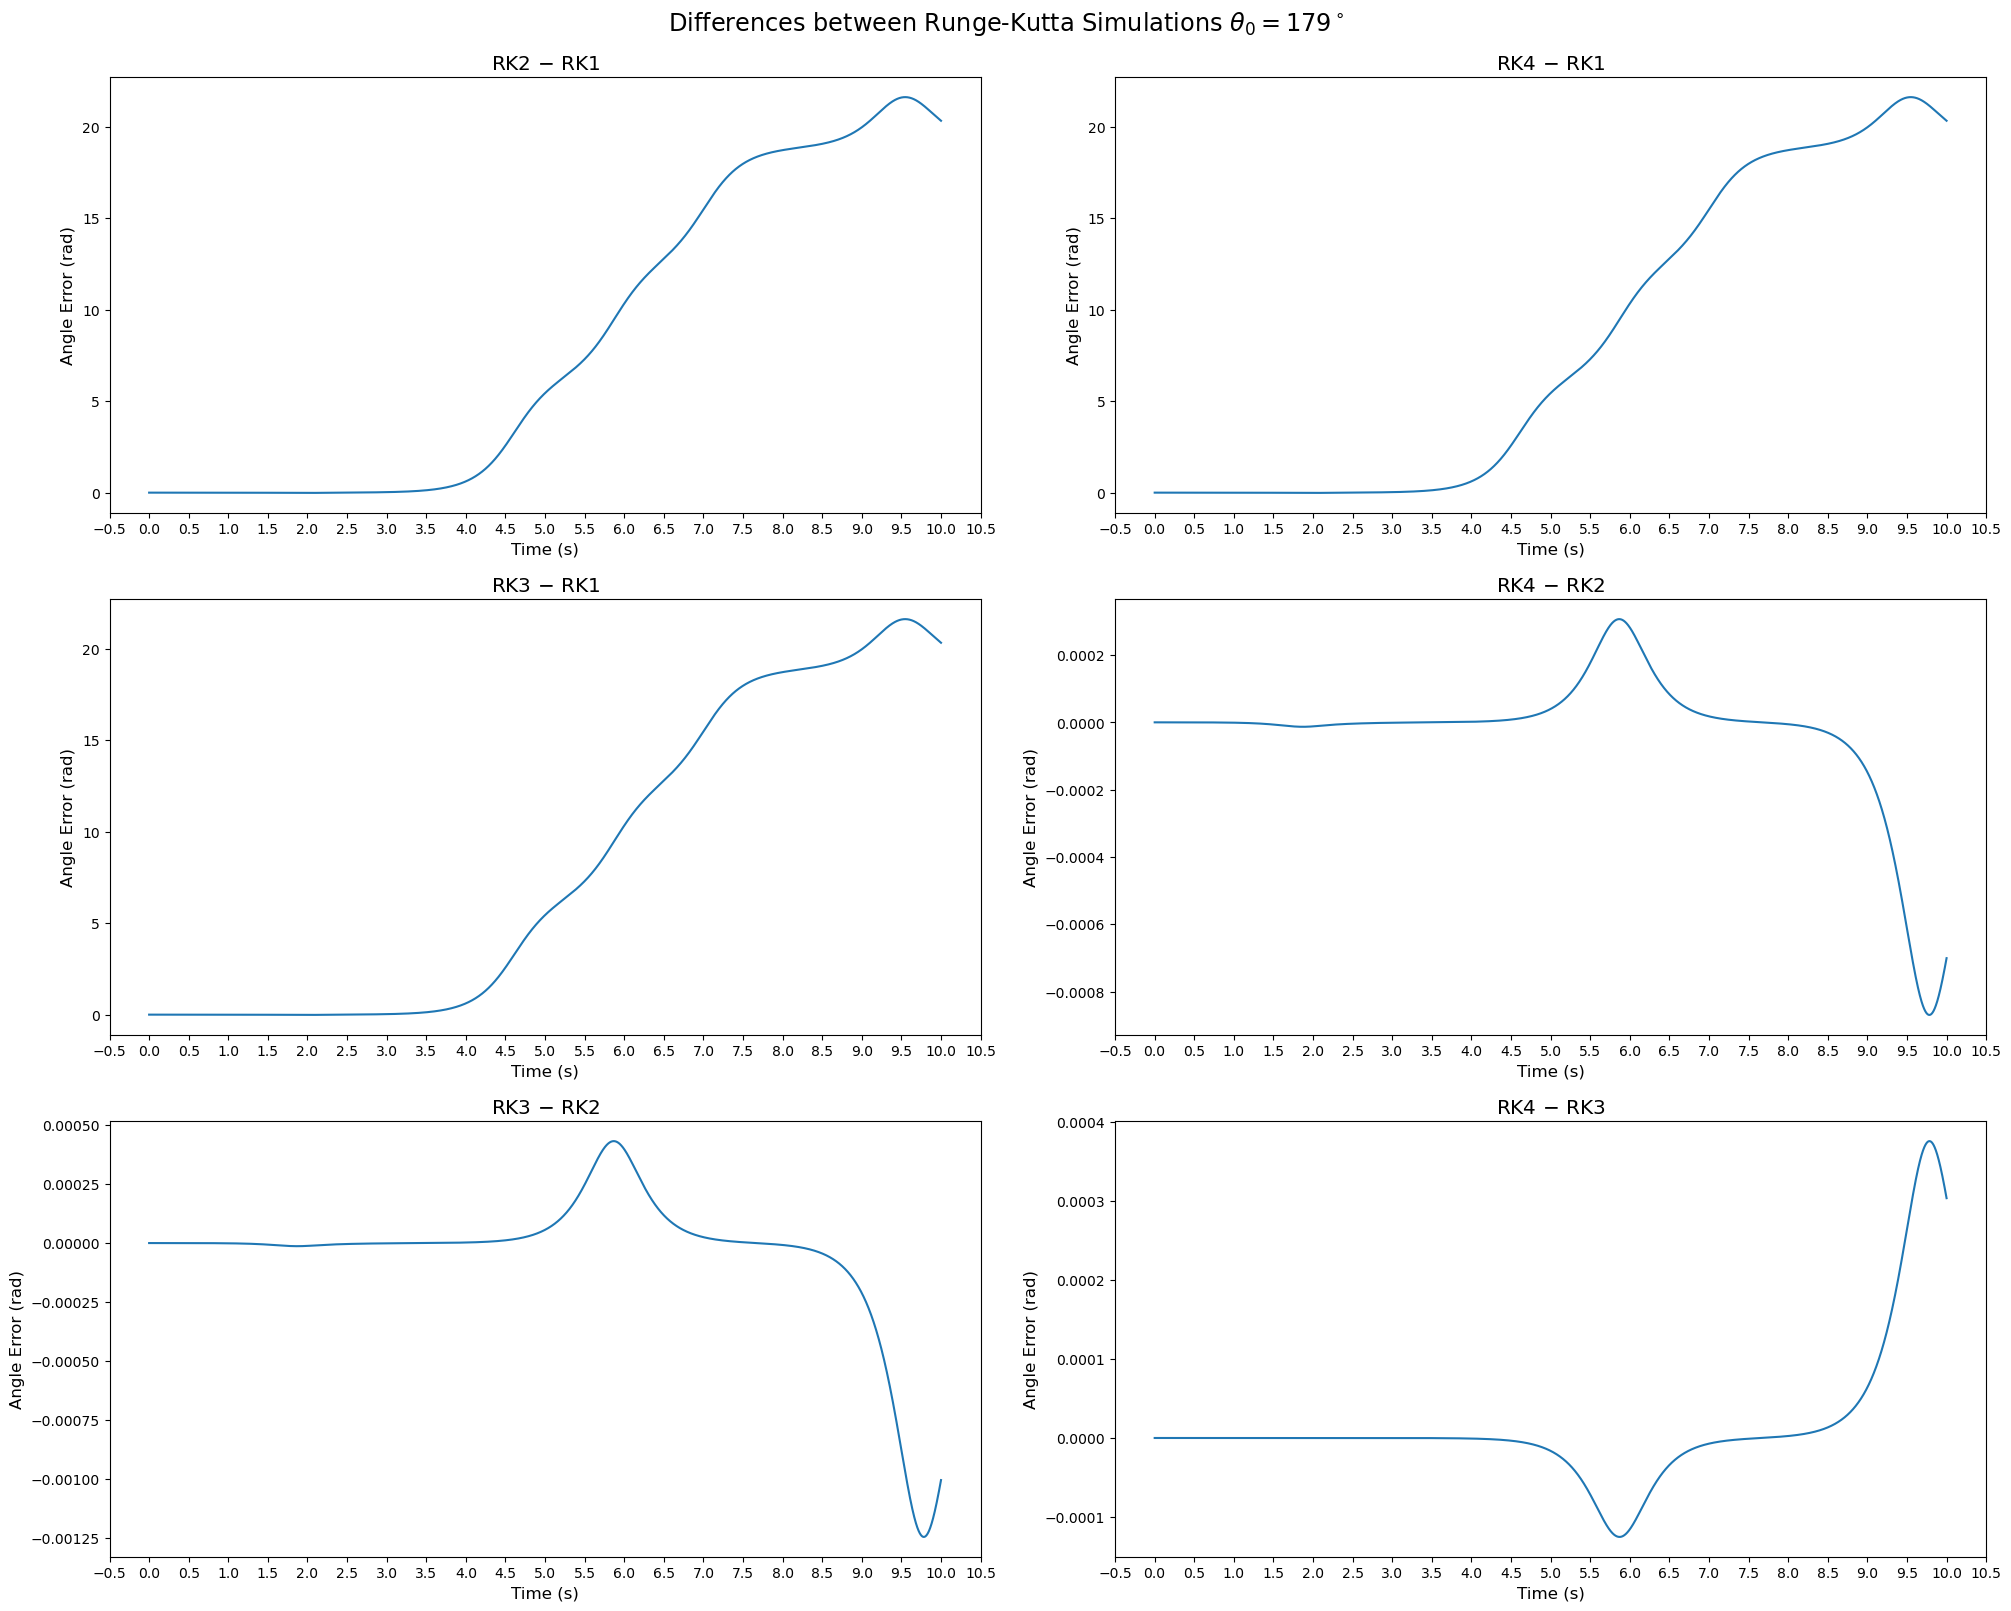

In [33]:
plot_sims(*sim_data, angle_i=angle_i, duration=duration)
plot_errors(*sim_data, angle_i=angle_i, duration=duration)
plot_rkdiffs(*(np.delete(sim_data, [1, 2], axis=0)), angle_i=angle_i, duration=duration)